# Setup

In [12]:
import os
import copy
import re

# Progress bar
from tqdm import tqdm

# Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Reshape, Conv1D, MaxPool1D, GlobalAveragePooling1D, BatchNormalization, Dense, Activation, Dropout
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
project_abs_path = "/Users/fujiwaraseita/Desktop/microbit_remote_control_ML/Machine-Learning/"

train_raw = pd.read_csv(project_abs_path + 'train_raw.csv')
train_fft =  pd.read_csv(project_abs_path + 'train_fft.csv')
train_median_fft = pd.read_csv(project_abs_path + 'train_median_fft.csv')

In [9]:
# train_raw.head()

In [10]:
# train_fft.head()

In [11]:
# train_median_fft.head()

#  Split data into train & test

Since I would like to have a few data for test from each labels, I split manually

In [4]:
def split_data_into_train_and_test(df: pd.DataFrame, test_percentage:int=0.2)->(pd.DataFrame, pd.DataFrame):

    train_df = df.copy()
    test_df = pd.DataFrame()

    # Get test data from each gesture
    for gesture, group in df.groupby('Gesture'):
   
        # Get unique Ids for the current gesture
        unique_ids = group['Id'].unique()
        
        # Calculate the number of Ids for test data
        num_test_ids = int(len(unique_ids) * test_percentage)

        # DEBUG:
        # print(f"{gesture}:")
        # print(f"Unique Id count: {unique_ids}")
        # print(f"{num_test_ids}")
        
        # Randomly select Ids for test data
        test_ids = pd.Series(unique_ids).sample(n=num_test_ids, random_state=42).values
        
        # Select rows for test_df where Id is in test_ids and Gesture matches
        test_data = group[group['Id'].isin(test_ids)]
        
        # Append selected test data to test_df
        test_df = pd.concat([test_df, test_data], ignore_index=True)
        
        # Drop the test data rows from train_df
        train_df = train_df.drop(test_data.index)
        
            
    return train_df, test_df

In [5]:
train_fft_df, test_fft_df = split_data_into_train_and_test(train_fft)

In [74]:
# train_fft_df

In [75]:
# test_fft_df

# Reshaping for model

In [6]:
def reshape_df(df: pd.DataFrame, max_rows: int, features_list: list=['X_fft', 'Y_fft', 'Z_fft'],
               label_col: str = 'Gesture') -> (np.ndarray, np.ndarray):
    """
    Reshape the dataframe into a 3D array with shape (total_samples, rows, features)
    and apply one-hot encoding to the labels.
    """
    # Perform one-hot encoding on the labels
    y_one_hot = pd.get_dummies(df[label_col]).values
    
    # Extract only the 3 desired features (default: X_fft, Y_fft, Z_fft)
    df_features = df[features_list]

    # Reshape the features into 3D (total_samples, rows, features)
    num_samples = len(df_features) // max_rows
    x_train = df_features.values[:num_samples * max_rows].reshape(num_samples, max_rows, -1)
    
    # Take the first label in each chunk of `rows` for the one-hot encoded labels
    y_labels = y_one_hot[::max_rows][:num_samples]
    y_labels = y_labels.astype(int)

    return x_train, y_labels

In [8]:
x_train, y_train_labels = reshape_df(train_fft_df, max_rows=50, label_col='Gesture')

print("x_train shape:", x_train.shape)  # Ex: (all samples, data rows, features)
print("y_labels shape:", y_train_labels.shape)  # Ex: (all samples, class nums)

x_train shape: (158, 50, 3)
y_labels shape: (158, 6)


In [9]:
print(y_train_labels[:5])

[[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]


In [80]:
## Input and Output Dimensions
# time_period, sensors = x_train.shape[1], x_train.shape[2]

In [81]:
## reshaping data
# input_shape = time_period * sensors
# x_train = x_train.reshape(x_train.shape[0], input_shape)
# print("Input Shape: ", input_shape)
# print("Input Data Shape: ", x_train.shape)

Input Shape:  150
Input Data Shape:  (95, 150)


# LSTM

In [13]:
# reshape (95, 50, 3) 
model = Sequential()
model.add(Input(shape=(50, 3)))  # ここで最初に入力の形状を指定

model.add(LSTM(32, return_sequences=True, activation='relu'))
model.add(LSTM(32, return_sequences=True, activation='relu'))

# LSTM出力の形状 (50, 32) を Conv1D の入力に適した形状に調整
model.add(Reshape((50, 32)))

# Conv1Dレイヤーで特徴量を抽出
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', strides=2))
model.add(MaxPool1D(pool_size=4, padding='same'))
model.add(Conv1D(filters=192, kernel_size=2, activation='relu', strides=1))

# GlobalAveragePooling1Dで出力を縮約し、Reshapeレイヤーを省略
model.add(GlobalAveragePooling1D())

model.add(BatchNormalization(epsilon=1e-06))
model.add(Dense(6))
model.add(Activation('softmax'))

# # Early stopping コールバックの設定
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Dropoutを追加したモデルの構築
# model = Sequential()
# model.add(LSTM(32, return_sequences=True, input_shape=(50, 3), activation='relu'))
# model.add(Dropout(0.3))  # Dropout レイヤー追加
# model.add(LSTM(32, return_sequences=True, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Reshape((50, 32)))
# model.add(Conv1D(filters=64, kernel_size=2, activation='relu', strides=2))
# model.add(MaxPool1D(pool_size=4, padding='same'))
# model.add(Conv1D(filters=192, kernel_size=2, activation='relu', strides=1))
# model.add(GlobalAveragePooling1D())
# model.add(BatchNormalization(epsilon=1e-06))
# model.add(Dense(6))
# model.add(Activation('softmax'))

# print(model.summary())

## dataset 1 (Normal FFT)

In [14]:
x_test, y_test_labels = reshape_df(test_fft_df, max_rows=50, label_col='Gesture')

In [16]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
history = model.fit(x_train,
                    y_train_labels, 
                    batch_size=192, 
                    epochs=30,
                    validation_data=(x_test, y_test_labels),  # 検証データとしてx_testとy_test_hotを指定
                    # callbacks=[early_stopping]  # Early stopping をコールバックに追加
                   )

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.2089 - loss: 2.0038 - val_accuracy: 0.2051 - val_loss: 4.5294
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.2911 - loss: 1.7264 - val_accuracy: 0.1795 - val_loss: 4.3730
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.4367 - loss: 1.4854 - val_accuracy: 0.1538 - val_loss: 4.8842
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5063 - loss: 1.3609 - val_accuracy: 0.1795 - val_loss: 5.2613
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6076 - loss: 1.3164 - val_accuracy: 0.2051 - val_loss: 5.3716
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6582 - loss: 1.1657 - val_accuracy: 0.2051 - val_loss: 5.3844
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.7342 - loss: 1.0878 - val_accuracy: 0.1795 - val_loss: 5.6350
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7532 - loss: 1.0326 - val_accuracy: 0.1795 - val_loss: 5.

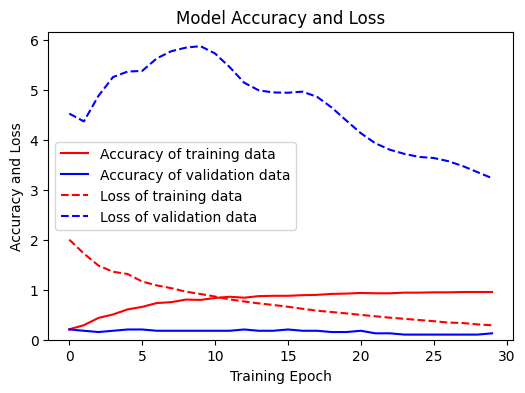

In [17]:
# トレーニング精度と損失のプロット
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')  # 検証データの精度
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')  # 検証データの損失
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1376 - loss: 3.2951
Accuracy on Test Data: 0.12820513546466827
Loss on Test Data: 3.2358720302581787
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step


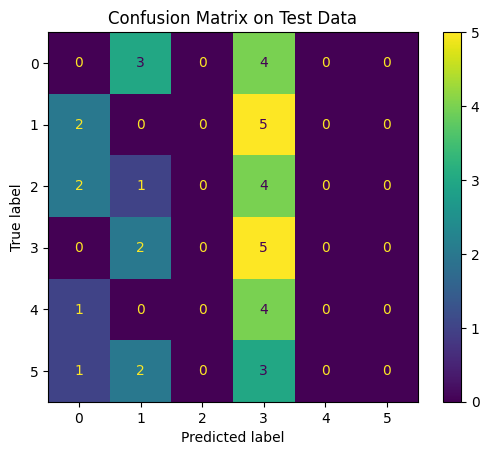

In [18]:
# テストデータでの評価と混同行列
score = model.evaluate(x_test, y_test_labels)
print("Accuracy on Test Data:", score[1])
print("Loss on Test Data:", score[0])

# テストデータでの予測
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
y_test_pred = np.argmax(y_test_labels, axis=1)

# 混同行列の表示
cm = confusion_matrix(y_test_pred, predictions)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_disp.plot()
plt.title("Confusion Matrix on Test Data")
plt.show()

## dataset 2 (Removed Noise FFT)

## dataset 3 (Normal)

In [119]:
train_raw_df, test_raw_df = split_data_into_train_and_test(train_raw, 0.2)
x_raw_train, y_raw_train_labels = reshape_df(train_raw_df, max_rows=50, features_list=['X', 'Y', 'Z'], label_col='Gesture')
x_raw_test, y_raw_test_labels = reshape_df(test_raw_df, max_rows=50, features_list=['X', 'Y', 'Z'], label_col='Gesture')

print("x_train shape:", x_raw_train.shape)  # Ex: (all samples, data rows, features)
print("y_labels shape:", y_raw_train_labels.shape)  # Ex: (all samples, class nums)

x_train shape: (129, 50, 3)
y_labels shape: (129, 6)


In [120]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
history = model.fit(x_train,
                    y_train_labels, 
                    batch_size=192, 
                    epochs=30,
                    validation_data=(x_test, y_test_labels),  # 検証データとしてx_testとy_test_hotを指定
                    callbacks=[early_stopping]  # Early stopping をコールバックに追加
                   )

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.2526 - loss: 1.9072 - val_accuracy: 0.1739 - val_loss: 1.7889
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.2211 - loss: 1.9743 - val_accuracy: 0.1739 - val_loss: 1.7859
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.3789 - loss: 1.6254 - val_accuracy: 0.1739 - val_loss: 1.7837
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.4632 - loss: 1.5140 - val_accuracy: 0.1739 - val_loss: 1.7822
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3789 - loss: 1.4174 - val_accuracy: 0.2609 - val_loss: 1.7813
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.5053 - loss: 1.3558 - val_accuracy: 0.2609 - val_loss: 1.7802
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.4737 - loss: 1.2058 - val_accuracy: 0.3043 - val_loss: 1.7790
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.5579 - loss: 1.1859 - val_accuracy: 0.2609 - val_loss: 1.

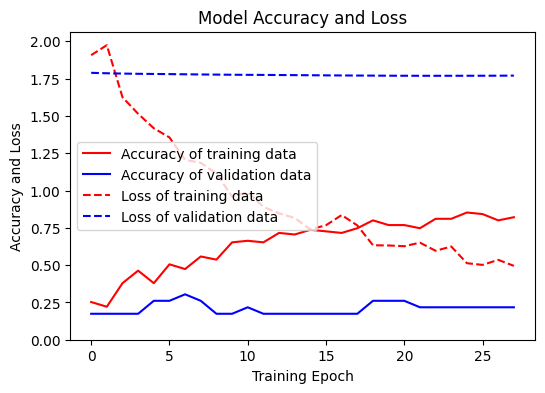

In [121]:
# トレーニング精度と損失のプロット
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')  # 検証データの精度
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')  # 検証データの損失
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2174 - loss: 1.7689
Accuracy on Test Data: 0.21739129722118378
Loss on Test Data: 1.7688921689987183
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


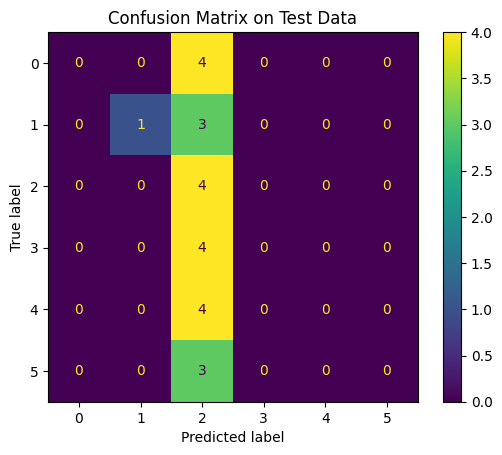

In [122]:
# テストデータでの評価と混同行列
score = model.evaluate(x_test, y_test_labels)
print("Accuracy on Test Data:", score[1])
print("Loss on Test Data:", score[0])

# テストデータでの予測
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
y_test_pred = np.argmax(y_test_labels, axis=1)

# 混同行列の表示
cm = confusion_matrix(y_test_pred, predictions)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_disp.plot()
plt.title("Confusion Matrix on Test Data")
plt.show()

# Summary